In [52]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# import data

In [8]:
df = pd.read_csv('../raw_data/time_series/wwwusage.csv',names = ['value'],header = 0)

<AxesSubplot:>

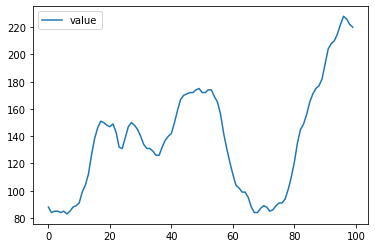

In [9]:
df.plot()

# build model

## stationary,differentiate

In [11]:
y = df.value
adfuller(y)[1] # check p-value

0.1244193544710952

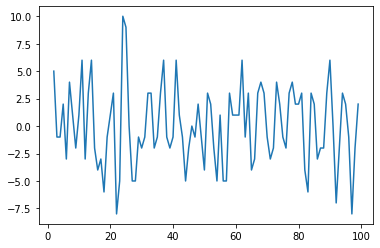

In [15]:
plt.plot(y.diff().diff())

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`]

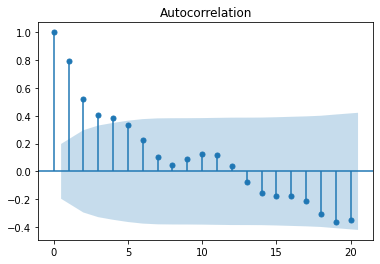

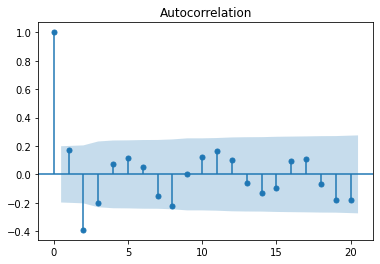

In [19]:
plot_acf(y.diff().dropna());
plot_acf(y.diff().diff().dropna());

In [30]:
q = 1

In [20]:
d = 1
y_diff = y.diff().dropna()
#ndiffs(y)

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`]

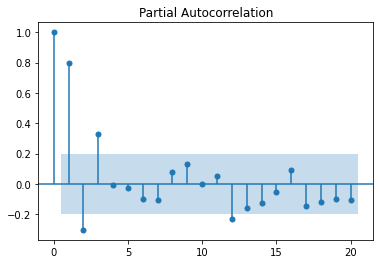

In [26]:
plot_pacf(y_diff);

In [28]:
p = 1 

In [31]:
# build model_1

arima = ARIMA(y,order = (1,1,1))
arima = arima.fit()
arima.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56402D+00    |proj g|=  2.59166D-03

At iterate    5    f=  2.56353D+00    |proj g|=  6.48193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   0.000D+00   2.564D+00
  F =   2.5635313471499463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Tue, 21 Jun 2022   AIC                            515.579
Time:                        13:53:59   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089      5.932      0.000       0.355       0.705
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5764           +0.0000j            1.5764            0.0000
MA.1           -1.8879           +0.0000j            1.8879            0.5000
-----------------------------------------------------------------------------
"""

Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_.

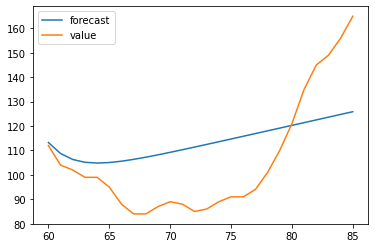

In [37]:
arima.plot_predict(60,85,dynamic=True);

## grid search

In [51]:
model = pm.auto_arima(y,
                       start_p=1, max_p=5,
                       start_q=1, max_q=5,
                       seasonal=False,
                       trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=564.832, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1277.994, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=529.183, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=531.096, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=534.894, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=532.642, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=526.492, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=564.487, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=538.940, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=528.287, Time=0.05 sec
 

In [40]:
# out of sample forecast

y_train = y.iloc[:85]
y_test = y.iloc[85:]

arima = ARIMA(y_train,order=(2,0,2))
arima = arima.fit(disp=0)

forecast,std_err,confidence_int = arima.forecast(steps=15)

In [41]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

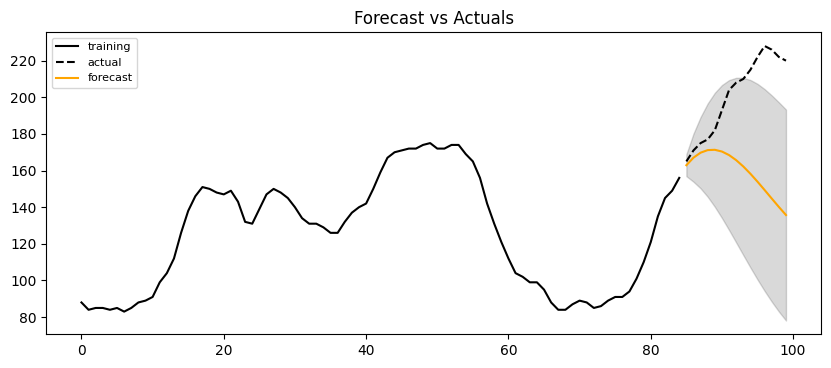

In [42]:
plot_forecast(forecast,y_train,y_test,confidence_int[:,0], confidence_int[:,1])

## evaluate model

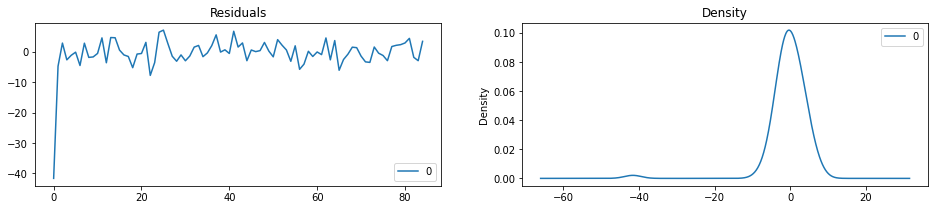

In [44]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1., 18., 45., 20.]),
 array([-41.6220129 , -36.74169507, -31.86137725, -26.98105942,
        -22.1007416 , -17.22042377, -12.34010595,  -7.45978812,
         -2.5794703 ,   2.30084753,   7.18116535]),
 <BarContainer object of 10 artists>)

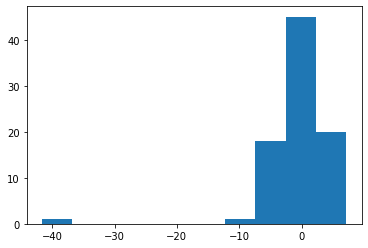

In [45]:
plt.hist(arima.resid)

In [48]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [49]:
y_pred = pd.Series(forecast,index=y_test.index)

forecast_accuracy(y_pred,y_test)

{'mape': 0.19377312714992587,
 'me': -41.79433889709815,
 'mae': 41.79433889709815,
 'mpe': -0.19377312714992587,
 'rmse': 51.95816122690316,
 'acf1': 0.855508486652663,
 'corr': -0.7474583024722502,
 'minmax': 0.19377312714992578}

## cross-validate model performance 

In [53]:
range_p = [0,1,2]
range_d = [1,2]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
        model = ARIMA(y_train, order=order).fit()
        # y_pred = model.forecast(len(y_test))[0] for unknown reason this crash
        # r2s.append(r2_score(y_pred, y_true))
        orders.append(order)
        aics.append(model.aic)
        
        
df = pd.DataFrame(list(zip(fold_idxs, orders, aics)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC'])#, 'R2'])

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11532D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   3.115D+00
  F =   3.1153239200110812     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63640D+00    |proj g|=  2.67302D-03

At iterate    5    f=  2.63638D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   0.000D+00   2.636D+00
  F =   2.6363787108532897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58206D+00    |proj g|=  5.45692D-03

At iterate    5    f=  2.58034D+00    |proj g|=  4.99867D-04

At iterate   10    f=  2.58032D+00    |proj g|=  2.13607D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   8.882D-08   2.580D+00
  F =   2.5803228259390063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.57631D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   0.000D+00   2.576D+00
  F =   2.5763137482424163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58084D+00    |proj g|=  6.69003D-03

At iterate    5    f=  2.58037D+00    |proj g|=  6.72218D-04

At iterate   10    f=  2.58033D+00    |proj g|=  1.77636D-07

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  2.54242D+00    |proj g|=  5.67546D-05

At iterate   40    f=  2.54242D+00    |proj g|=  1.81322D-04

At iterate   45    f=  2.54242D+00    |proj g|=  1.15996D-04

At iterate   50    f=  2.54242D+00    |proj g|=  1.41709D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/yanyi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     51    226      5     0     0   1.417D-04   2.542D+00
  F =   2.5424244313431306     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58087D+00    |proj g|=  2.07901D-02

At iterate    5    f=  2.57836D+00    |proj g|=  4.15104D-03

At iterate   10    f=  2.57634D+00    |proj g|=  1.81690D-03

At iterate   15    f=  2.57630D+00    |proj g|=  1.86517D-06

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61797D+00    |proj g|=  3.37419D-03

At iterate    5    f=  2.61788D+00    |proj g|=  5.90372D-04

At iterate   10    f=  2.61787D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   4.441D-08   2.618D+00
  F =   2.6178748606987194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


In [55]:
# lower AIC , the better
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

(p,d,q)
(1, 2, 2)    262.447119
(2, 2, 0)    262.834904
(1, 1, 1)    263.617282
(2, 2, 2)    263.941706
(2, 2, 1)    264.370436
(0, 1, 2)    264.391466
(0, 2, 2)    264.502597
(1, 1, 2)    265.182933
(2, 1, 1)    265.392450
(2, 1, 2)    265.999363
(2, 1, 0)    266.245564
(0, 2, 1)    266.741953
(1, 2, 1)    267.389295
(0, 2, 0)    268.017320
(1, 2, 0)    268.875440
(1, 1, 0)    268.978342
(0, 1, 1)    272.315613
(0, 1, 0)    305.073583
Name: AIC, dtype: float64